## Direct Optimization + A* sampling for TSP 

In [1]:
import os
import numpy as np
import torch
import matplotlib
import matplotlib.pyplot as plt
import string
%matplotlib inline

In [2]:
from utils import load_model
import dirpg
from a_star_sampling import Node, Trajectory



In [3]:

class opts:
    def __init__(self,
                 max_interactions=200,
                 alpha=1.0,
                 epsilon=2.0,
                 heuristic='mst',
                 independent_gumbel=False,
                 first_improvement=False,
                 dynamic_weighting = False,
                 dfs_like=False,
                 not_prune=False):        
        self.max_interactions = max_interactions
        self.first_improvement = first_improvement
        self.dynamic_weighting = dynamic_weighting
        self.independent_gumbel = independent_gumbel
        self.heuristic = heuristic
        self.dfs_like = dfs_like
        self.not_prune = not_prune
        self.alpha=alpha
        self.epsilon = epsilon

dirpg_opts = opts()
num_cities = 8
model, _ = load_model('outputs/tsp_{}/jupyter_example/DirPG_20200506T134440/'.format(num_cities), epoch = 0) # 'pretrained/tsp_100/')
#model, _ = load_model('outputs/tsp_{}/visuals/DirPG_20200421T162602/'.format(num_cities), epoch = 1)
#model, _ = load_model('outputs/tsp_{}/2epochs_ours/DirPG_20200506T004445/'.format(num_cities), epoch = 0)
model.eval()  # Put in evaluation mode to not track gradients
dirpg = dirpg.DirPG(model, dirpg_opts)

  [*] Loading model from outputs/tsp_8/jupyter_example/DirPG_20200506T134440/epoch-0.pt


In [4]:
import heapq
from utils import utils_gumbel
import networkx as nx
import time

class PriorityQueue:
    def __init__(self,
                 init_state,
                 distance_mat,
                 epsilon,
                 search_params,
                 inference=False
                 ):
        self.queue = []
        self.G = nx.Graph()
        
        Node.epsilon = epsilon
        init_state = init_state._replace(first_a=init_state.first_a.squeeze(0),
                                         prev_a=init_state.prev_a.squeeze(0),
                                         visited_=init_state.visited_.squeeze(0),
                                         lengths=init_state.lengths.squeeze(0),
                                         cur_coord=init_state.cur_coord.squeeze(0),
                                         ids=init_state.ids.squeeze(0),
                                         i=init_state.i.squeeze(0))

        special_action = init_state.prev_a.item()
        not_visited = [i for i in range(init_state.loc.size(1)) if i != special_action]
        self.first_coord = init_state.loc[init_state.ids, special_action]
        self.graph_size = distance_mat.shape[1]

        #           global nodes parameters      #
        Node.alpha = search_params['alpha']
        Node.epsilon = epsilon
        Node.dynamic_weighting = search_params['dynamic_weighting']
        Node.heuristic = search_params['heuristic']
        Node.graph_size = self.graph_size
        Node.dist = distance_mat
        
        self.root_node = Node(id=init_state.ids,
                         first_a=init_state.first_a.item(),
                         next_actions=not_visited, # torch.tensor(not_visited),  # number of cities
                         not_visited=not_visited,
                         prefix=[special_action],
                         lengths=0.0,
                         cur_coord=self.first_coord,
                         max_gumbel=utils_gumbel.sample_gumbel(0),
                         t_opt=True)
        self.G.add_node(self.root_node)
        
        heapq.heappush(self.queue, self.root_node)

        if search_params['independent_gumbel']:
            direct_node = copy.copy(self.root_node)
            direct_node.t_opt = False
            heapq.heappush(self.queue, direct_node)
            
        self.current_node = self.root_node
        self.id = init_state.ids.item()

        self.trajectories_list = []
        self.t_opt = None
        self.t_direct = None

        self.prune_count = 0

        self.orig_dist = distance_mat
        self.start_search_direct = False
        self.start_time = float('Inf')
        # self.max_search_time = max_search_time
        self.num_interactions = 0
        self.first_improvement = search_params['first_improvement']
        self.max_interactions = search_params['max_interactions']
        self.dfs_like = search_params['dfs_like']
        self.p = search_params['prune']
        self.dynamic_weighting = search_params['dynamic_weighting']
        self.inference = inference
        self.prune = False
    
        self.lower_bound = -float('Inf')
        
        #######  plotting  #######
        #priority-queue:
        self.labels = {self.root_node : 'root'}
        self.nodes_opt = []
        self.other_nodes = []
        self.ids = 1
        self.direct_node = None
        
        #prefix:
        

    def pop(self):

        if not self.queue:
            print('the queue is empty')
            return 'break'

        parent = heapq.heappop(self.queue)
        self.current_node = parent

        if self.num_interactions >= self.max_interactions:
            print('interactions budget is over')
            return 'break'

        if self.prune and self.lower_bound > parent.upper_bound:
            self.prune_count += 1
            return self.pop()

        # Start the search time count
        if not parent.t_opt and not self.start_search_direct:
            self.start_time = time.time()
            self.start_search_direct = True

        if parent.done:
            return self.set_trajectory(parent)

        return parent

    def set_trajectory(self, node):

        t = Trajectory(actions=node.prefix,
                       gumbel=node.max_gumbel,
                       length=node.lengths - (self.first_coord - node.cur_coord).norm(p=2, dim=-1),
                       objective=node.objective)

        self.trajectories_list.append(t)

        if node.t_opt:
            self.t_opt = t
            self.t_direct = t
            self.direct_node = node
            self.lower_bound = t.objective
            if self.inference:                
                return 'break'
        else:
            if t.objective > self.t_direct.objective:
                # if len(self.trajectories_list) > 2:
                #    print('here: ', len(self.trajectories_list))
                self.t_direct = t
                self.lower_bound = t.objective
                self.direct_node = node
                if self.first_improvement:
                    #print('*****  priority(direct) > priority(opt)   *****')
                    print('first improvement')
                    return 'break'

        if self.queue:
            return self.pop()
        else:
            # print('break')
            print('5')
            return 'break'

    def expand(self, state, logprobs):

        self.num_interactions += 1
        special_action = state.prev_a.item()
        s = time.time()
        not_visited = [i for i in self.current_node.not_visited if i != special_action]
        cur_coord = state.loc[self.current_node.id, special_action]
        length = -(cur_coord - self.current_node.cur_coord).norm(p=2, dim=-1)

        #updated_prefix = self.current_node.prefix + [special_action]

        #dist = np.delete(np.delete(self.orig_dist, self.current_node.prefix[1:], 0), self.current_node.prefix[1:], 1)
        #print('******** orig ******')
        #print(self.orig_dist)
        #print('******** mod ******')
        #print(dist)
        special_child = Node(
            id=self.current_node.id,
            first_a=self.current_node.first_a,
            not_visited=not_visited,
            prefix=self.current_node.prefix + [special_action],
            lengths=self.current_node.lengths + length,
            cur_coord=cur_coord,
            done=len(not_visited) == 0,
            logprob_so_far=self.current_node.logprob_so_far + logprobs[special_action],
            max_gumbel=self.current_node.max_gumbel,
            next_actions=not_visited,
            depth=self.current_node.depth + 1,
            t_opt=self.current_node.t_opt,
            dfs_like=self.dfs_like)
        
        if special_child.t_opt:
            self.nodes_opt.append(special_child)
        else:
            self.other_nodes.append(special_child)
            
        self.G.add_edge(self.current_node, special_child)
        self.labels[special_child] = str(self.ids)
        self.ids+=1
        if self.prune and special_child.upper_bound < self.lower_bound:
            self.prune_count += 1

        else:
            heapq.heappush(self.queue, special_child)

        # Sample the max gumbel for the non-chosen actions and create an "other
        # children" node if there are any alternatives left.

        m = time.time()
        other_actions = [i for i in self.current_node.next_actions if i != special_action]

        assert len(other_actions) == len(self.current_node.next_actions) - 1
        other_children = None
        if other_actions and not self.inference:
            other_max_location = utils_gumbel.logsumexp(logprobs[other_actions])
            other_max_gumbel = utils_gumbel.sample_truncated_gumbel(self.current_node.logprob_so_far + other_max_location,
                                                                    self.current_node.max_gumbel).item()
            other_children = Node(
                id=self.current_node.id,
                first_a=self.current_node.first_a,
                not_visited=self.current_node.not_visited,
                prefix=self.current_node.prefix,
                lengths=self.current_node.lengths,
                cur_coord=self.current_node.cur_coord,
                done=self.current_node.done,
                logprob_so_far=self.current_node.logprob_so_far,
                max_gumbel=other_max_gumbel,
                next_actions=other_actions,
                depth=self.current_node.depth + 1,
                upper_bound=self.current_node.upper_bound,
                t_opt=False,
                dfs_like=False)
            
            self.other_nodes.append(other_children)
            
            self.G.add_edge(self.current_node, other_children)
            self.labels[other_children] = str(self.ids)
            self.ids+=1
            if self.prune and other_children.upper_bound < self.lower_bound:
                self.prune_count += 1
            else:
                heapq.heappush(self.queue, other_children)

        f = time.time()
        sp = m - s
        oth = f - m
        return special_child, other_children



In [5]:
def encode(x, dirpg):
    embeddings = dirpg.encoder(x, only_encoder=True)
    state = dirpg.encoder.problem.make_state(x)
    fixed = dirpg.encoder.precompute(embeddings)
    return state, fixed


x = torch.rand(1, 20, 2)

def init_queue(x, dirpg, epsilon=1.0, alpha=1.0, start_from = 0):
    dirpg.search_params['alpha'] = alpha 
    state, fixed = encode(x, dirpg)
    _, state = dirpg.forward_and_update(state, fixed, first_action=start_from)
    return PriorityQueue(init_state=state[torch.tensor(0)],
                         distance_mat=state.dist[0],
                         epsilon = epsilon,
                         inference=False,
                         search_params=dirpg.search_params), state, fixed


In [6]:
def sample(queue, fixed, state):
    
    while queue:
        parent = queue.pop()
        if parent == 'break':
            return queue

        batch_state = state.stack_state([parent])
        log_p, state = dirpg.forward_and_update(batch_state, fixed)

        queue.expand(state[torch.tensor(0)], log_p[0])
    
queue,state, fixed = init_queue(x, dirpg)
queue = sample(queue, fixed, state)
print(queue.num_interactions)

TypeError: unsupported operand type(s) for *: 'float' and 'NoneType'

## Interactive tree plot

In [7]:
plt.rcParams['figure.figsize'] = [16, 6]

In [8]:
np.random.seed(3)
torch.manual_seed(3)
x = torch.rand(1, num_cities, 2)
#x = torch.load('good_example_8graph')
abc = string.ascii_lowercase[:x.size(1)]

In [9]:
direct, first_direct = None, True
queue,state, fixed = init_queue(x, dirpg, epsilon=2.0, alpha=1.0)

### Press Ctrl+Entr to expand the queue

#### Left: priority queue,   Right: prefix of the current node (yellow node in the left fig)

special child prefix: 
['a', 'd']
depth:  1


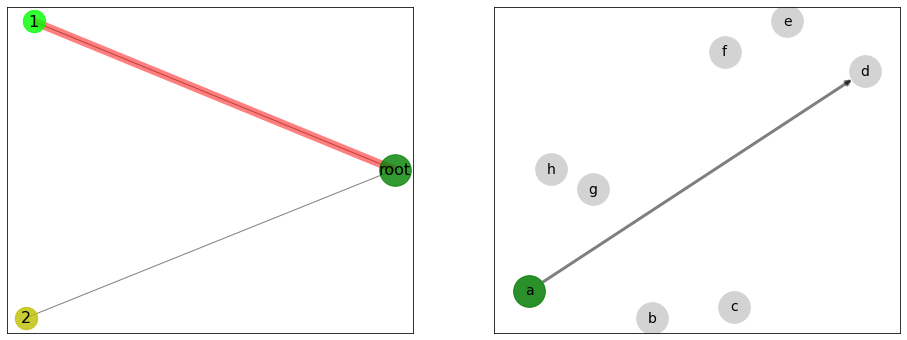

In [10]:
cities = nx.DiGraph()
cities.add_nodes_from(range(x.size(1)))
parent = queue.pop()


if parent == 'break':
    print('END')
else:
    batch_state = state.stack_state([parent])
    log_p, state = dirpg.forward_and_update(batch_state, fixed)

    sp, oth = queue.expand(state[torch.tensor(0)], log_p[0])
    
    if queue.t_opt is not None:
        print('t_opt: ')
        print([abc[i] for i in queue.t_opt.actions])
    if queue.t_direct is not None:
        print('t_direct: ')
        print([abc[i] for i in queue.t_direct.actions])
    print('special child prefix: ')
    print([abc[i] for i in sp.prefix])
    
    
    print('depth: ', sp.depth)
    
    plt.subplot(121)
    pos = nx.kamada_kawai_layout(queue.G)
    # nx.draw_networkx(queue.G,pos=pos, with_labels=False, font_weight='bold')
    colors = []
    nx.draw_networkx_nodes(queue.G, pos,
                           nodelist=[queue.root_node],                           
                           node_size = 1000,
                           node_color='g',
                           alpha=0.8)
    opt_nodes = [i for i in queue.nodes_opt if i!=sp]
    nx.draw_networkx_nodes(queue.G, pos,
                           nodelist=opt_nodes,
                           node_size = 500,                           
                           node_color='r',
                           alpha=0.5)
    
    in_queue = [i for i in queue.other_nodes if i in queue.queue]
    nx.draw_networkx_nodes(queue.G, pos,
                           nodelist=in_queue,
                           node_size = 500,
                           node_color='y',
                           alpha=0.8)
    
    out_of_queue = [i for i in queue.other_nodes if i not in queue.queue]
    nx.draw_networkx_nodes(queue.G, pos,
                           nodelist=out_of_queue,
                           node_size = 500,
                           node_color=[(0.2,0.2,0.2) for _ in range(len(out_of_queue))],
                           alpha=0.6)    
            
    nx.draw_networkx_nodes(queue.G, pos,
                           nodelist=[sp],
                           node_size = 500,                           
                           node_color=[(0.0,1.0,0.0)],
                           alpha=0.8)
    """
    if first_direct and queue.t_direct != queue.t_opt:        
        first_direct = False
        direct = queue.t_direct
    """
    if queue.direct_node is not None:
        """
        if direct != queue.t_direct:
            direct = queue.t_direct
         
        """   
        nx.draw_networkx_nodes(queue.G, pos,
                               nodelist=[queue.direct_node],
                               node_shape='^',
                               node_size = 800,                           
                               node_color=[(0.0,1.0,0.0)],
                               alpha=0.8) 

            


    
    nx.draw_networkx_edges(queue.G, pos, width=1.0, alpha=0.5)


    nx.draw_networkx_edges(queue.G, pos,
                           edgelist=[(parent, sp)],
                           width=8, alpha=0.5, edge_color='r')

    
        
    nx.draw_networkx_labels(queue.G, pos, labels= queue.labels, font_size=16)
    
    #####################
    
    plt.subplot(122)
    pos2 = {i:loc.numpy() for i,loc in enumerate(x[0])} 
    edgelist = [(sp.prefix[i],sp.prefix[i+1]) for i in range(len(sp.prefix)) if i<len(sp.prefix)-1]
    
    nx.draw_networkx_nodes(cities, pos2,                            
                           node_size = 1000,
                           node_color='lightgrey',
                           alpha=1.0) 
    
    nx.draw_networkx_nodes(cities, pos2,
                           nodelist=[sp.prefix[0]], 
                           node_size = 1000,
                           node_color='g',
                           alpha=0.8)
    
    nx.draw_networkx_edges(cities, pos2,
                           edgelist=edgelist,
                           width=3, alpha=0.5, min_target_margin=15)
    
    if queue.t_opt is not None:
        a = queue.t_opt.actions
        edgelist = [(a[i],a[i+1]) for i in range(len(a)) if i<len(a)-1]
        nx.draw_networkx_edges(cities, pos2,
                               edgelist=edgelist,
                               width=8, alpha=0.3, edge_color='r',min_target_margin=15)
    
    if queue.t_direct != queue.t_opt:        
        a = queue.t_direct.actions
        edgelist = [(a[i],a[i+1]) for i in range(len(a)) if i<len(a)-1]
        nx.draw_networkx_edges(cities, pos2,
                               edgelist=edgelist,
                               width=8, alpha=0.3, edge_color='g',min_target_margin=15)


    l = {i:abc[i] for i in range(x.size(1))}
    
    nx.draw_networkx_labels(cities, pos2, labels=l, font_size=14)
    last_parent = parent
    
    #nx.draw_networkx(cities,pos, edgelist=edgelist, node_size= 500, node_color='lightgrey' )
    

## Node size: 
##### max Gumbel
## Node color: 
##### epsilon(length + 2MST)

In [11]:
def make_circule(n):
    G = nx.Graph()
    G.add_nodes_from(range(n))
    pos = nx.circular_layout(G, scale=0.5, center=(0.5,0.5))
    
    return torch.tensor([np.stack(list(pos.values()))], dtype = torch.float32)




In [12]:
def min_max_norm(x, a, b):
    min_x = np.min(x)
    max_x = np.max(x)
    return a + (((x - min_x)*(b-a))/(max_x - min_x))

def norm(x):
    return (x-np.mean(x))/np.std(x)

In [13]:
np.random.seed(4)
torch.manual_seed(4)
x = torch.rand(1, num_cities, 2)
# x = make_circule(num_cities)
#x = torch.load('good_example_8graph')


In [14]:
queue,state, fixed = init_queue(x, dirpg, epsilon=10.0, alpha=2.0)
update = False
direct, first_direct = None, True
parent = queue.pop()

In [15]:
Node.budget = dirpg_opts.max_interactions
update = not update    

cities = nx.DiGraph()
cities.add_nodes_from(range(x.size(1)))
if parent == 'break':
    print('END')
else:
    if update:        
        
        batch_state = state.stack_state([parent])
        log_p, state = dirpg.forward_and_update(batch_state, fixed)

        sp, oth = queue.expand(state[torch.tensor(0)], log_p[0])
    if queue.t_opt is not None:
        print('t_opt: ')
        print([abc[i] for i in queue.t_opt.actions])
    if queue.t_direct is not None:
        print('t_direct: ')
        print([abc[i] for i in queue.t_direct.actions])
        
    print('special child prefix: ')
    print([abc[i] for i in sp.prefix])
    print('prune count: ', queue.prune_count)
    print('lower bound: ',queue.lower_bound )
    print('scecial child: ')
    sp.print()
    print('other children: ')
    oth.print() if oth is not None else None    
    #print('scecial upper bound: ',sp.upper_bound)
    #print('others upper bound: ',oth.upper_bound) if oth is not None else None
    ax = plt.subplot(121)
    
    pos = nx.kamada_kawai_layout(queue.G)
    # nx.draw_networkx(queue.G,pos=pos, with_labels=False, font_weight='bold')
    
    nx.draw_networkx_nodes(queue.G, pos,
                           nodelist=[queue.root_node], 
                           node_size = 1000,
                           node_color='g',
                           alpha=0.8)

    nx.draw_networkx_edges(queue.G, pos, width=1.0, alpha=0.5)


    nx.draw_networkx_edges(queue.G, pos,
                           edgelist=[(parent, sp)],
                           width=8, alpha=0.5, edge_color=(0.0,1.0,0.0))
    """
    print('max_gumbel  +   eps*(- length - 2MST) = ')
    for i,j in zip([n.max_gumbel for n in queue.queue],
                  [Node.epsilon*n.get_upper_bound(2.0).item() for n in queue.queue]):
        
        print(i, ' +  ',j,  '  = ', i+j )
    """
    org_s = [n.max_gumbel for n in queue.queue]
    
    s2 = [300+4000.0*np.exp(n.max_gumbel) for n in queue.queue]
    s_mm = min_max_norm(org_s, a=np.min(org_s) ,b=np.max([5000,np.max(org_s)]))
    s_n = 300+100*norm(org_s)

    colors = [n.eps_reward.item() for n in queue.queue]

    nx.draw(queue.G, pos,
        nodelist=queue.queue,
        node_size=s2,
        node_color=colors,
        cmap=plt.cm.YlOrRd,
        alpha=0.8)
    
    out_of_queue = [i for i in queue.G if i not in queue.queue if i != queue.root_node]
    nx.draw_networkx_nodes(queue.G, pos,
                           nodelist=out_of_queue,
                           node_size = 500,
                           node_color=[(0.2,0.2,0.2) for _ in range(len(out_of_queue))],
                           alpha=0.6) 
    if not update:
        parent = queue.pop()
        ax.set_facecolor(color='none')
        nx.draw_networkx_nodes(queue.G, pos,ax=ax,
                               nodelist=[parent], 
                               node_size = 4000,
                               node_color='none',
                               linewidths=3.0,
                               node_shape = matplotlib.markers.MarkerStyle(marker='h', fillstyle='none'),
                               edgecolors='b')


    
    if queue.direct_node is not None:
        nx.draw_networkx_nodes(queue.G, pos,
                               nodelist=[queue.direct_node],
                               node_shape='*',
                               node_size = 1500,                           
                               node_color=[(0.0,1.0,0.0)],
                               alpha=0.8)
            

    nx.draw_networkx_labels(queue.G, pos, labels= queue.labels, font_size=16)
    
    #####################
    
    plt.subplot(122)
    pos2 = {i:loc.numpy() for i,loc in enumerate(x[0])} 
    edgelist = [(sp.prefix[i],sp.prefix[i+1]) for i in range(len(sp.prefix)) if i<len(sp.prefix)-1]
    
    nx.draw_networkx_nodes(cities, pos2,                            
                           node_size = 1000,
                           node_color='lightgrey',
                           alpha=1.0) 
    
    nx.draw_networkx_nodes(cities, pos2,
                           nodelist=[sp.prefix[0]], 
                           node_size = 1000,
                           node_color='g',
                           alpha=0.8)
    
    nx.draw_networkx_edges(cities, pos2,
                           edgelist=edgelist,
                           width=3, alpha=0.5, min_target_margin=15)
    
    if queue.t_opt is not None:
        a = queue.t_opt.actions
        edgelist = [(a[i],a[i+1]) for i in range(len(a)) if i<len(a)-1]
        nx.draw_networkx_edges(cities, pos2,
                               edgelist=edgelist,
                               width=8, alpha=0.2, edge_color='r',min_target_margin=15)
    
    if queue.t_direct != queue.t_opt:
        a = queue.t_direct.actions
        edgelist = [(a[i],a[i+1]) for i in range(len(a)) if i<len(a)-1]
        nx.draw_networkx_edges(cities, pos2,
                               edgelist=edgelist,
                               width=8, alpha=0.2, edge_color='g',min_target_margin=15)
        
        
        
    l = {i:abc[i] for i in range(x.size(1))}
    
  
    nx.draw_networkx_labels(cities, pos2, labels=l, font_size=14)
    
    

special child prefix: 
['a', 'e']
prune count:  0
lower bound:  -inf
scecial child: 
 -----------    Node     -----------
id:   tensor(0)
first_a:   0
prefix:   [0, 4]
not visited:   [1, 2, 3, 5, 6, 7]
next_actions:   [1, 2, 3, 5, 6, 7]
t:   2
distance matrix:
tensor([[0.0000, 0.5840, 0.7588, 0.5595, 0.4195, 0.4201, 0.3765, 0.2391],
        [0.5840, 0.0000, 0.1907, 1.1432, 0.9285, 0.2275, 0.8754, 0.7723],
        [0.7588, 0.1907, 0.0000, 1.3175, 1.1175, 0.3579, 1.0166, 0.9581],
        [0.5595, 1.1432, 1.3175, 0.0000, 0.3793, 0.9705, 0.4446, 0.4149],
        [0.4195, 0.9285, 1.1175, 0.3793, 0.0000, 0.8165, 0.5878, 0.1804],
        [0.4201, 0.2275, 0.3579, 0.9705, 0.8165, 0.0000, 0.6601, 0.6430],
        [0.3765, 0.8754, 1.0166, 0.4446, 0.5878, 0.6601, 0.0000, 0.4621],
        [0.2391, 0.7723, 0.9581, 0.4149, 0.1804, 0.6430, 0.4621, 0.0000]])
alpha*MST:  tensor(-4.0270)
priority:  -37.30284118652344
objective:  tensor(-5.4219)
upper bound:  tensor(-41.4974)
lengths:   tensor(-0.4195)
bo

## DFS vs BFS

### DFS: Nodes that extends a prefix are colored orange 
### BFS: Nodes that search for actions other than the last node are colored blue 
### Nodes that explore different prefix are colored yellow 

In [16]:
plt.rcParams['figure.figsize'] = [16, 6]
np.random.seed(4)
torch.manual_seed(4)
x = torch.rand(1, num_cities, 2)
# x = make_circule(num_cities)
#x = torch.load('good_example_8graph')


In [17]:
queue,state, fixed = init_queue(x, dirpg, epsilon=10.0, alpha=5.0)
update = False
direct, first_direct = None, True
dfs, bfs, others = [],[],[]
last_parent = None

special child prefix: 
['a', 'e']
depth:  1
alpha:  5.0


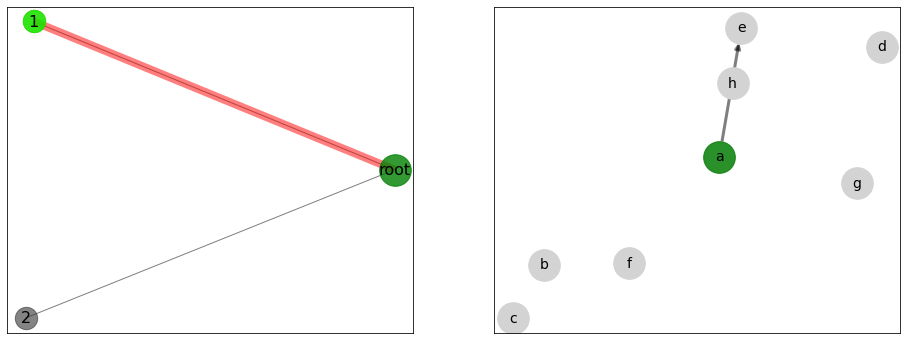

In [18]:
cities = nx.DiGraph()
cities.add_nodes_from(range(x.size(1)))
parent = queue.pop()


if parent == 'break':
    print('END')
else:
    batch_state = state.stack_state([parent])
    log_p, state = dirpg.forward_and_update(batch_state, fixed)

    sp, oth = queue.expand(state[torch.tensor(0)], log_p[0])
    

    if last_parent is not None and parent not in queue.nodes_opt:

        if parent.prefix == last_parent.prefix:
            bfs.append(parent)
        elif parent.prefix[:-1] == last_parent.prefix:
            dfs.append(parent)
        else:
            others.append(parent)
        
    if queue.t_opt is not None:
        print('t_opt: ')
        print([abc[i] for i in queue.t_opt.actions])
    if queue.t_direct is not None:
        print('t_direct: ')
        print([abc[i] for i in queue.t_direct.actions])
    print('special child prefix: ')
    print([abc[i] for i in sp.prefix])
    
    print('depth: ', sp.depth)
    print('alpha: ', sp.alpha)
    
    plt.subplot(121)
    pos = nx.kamada_kawai_layout(queue.G)
    # nx.draw_networkx(queue.G,pos=pos, with_labels=False, font_weight='bold')
    nx.draw_networkx_nodes(queue.G, pos,
                           nodelist=[queue.root_node],                           
                           node_size = 1000,
                           node_color='g',
                           alpha=0.8)
    opt_nodes = [i for i in queue.nodes_opt if i!=sp]
    nx.draw_networkx_nodes(queue.G, pos,
                           nodelist=queue.nodes_opt,
                           node_size = 500,                           
                           node_color='r',
                           alpha=0.5)
    
    others_nodes = [i for i in queue.other_nodes if i not in dfs+bfs+others]
    nx.draw_networkx_nodes(queue.G, pos,
                           nodelist=others_nodes,
                           node_size = 500,
                           node_color=[(0.2,0.2,0.2) for _ in range(len(others_nodes))],
                           alpha=0.6) 
    
    if dfs:
        nx.draw_networkx_nodes(queue.G, pos,
                               nodelist=dfs,
                               node_size = 500,
                               node_color='orange',
                               alpha=0.8)
    if bfs:
        nx.draw_networkx_nodes(queue.G, pos,
                               nodelist=bfs,
                               node_size = 500,
                               node_color='blue',
                               alpha=0.6)  
    if others:
        nx.draw_networkx_nodes(queue.G, pos,
                               nodelist=others,
                               node_size = 500,
                               node_color='magenta',
                               alpha=0.6)             
    nx.draw_networkx_nodes(queue.G, pos,
                           nodelist=[sp],
                           node_size = 500,                           
                           node_color=[(0.0,1.0,0.0)],
                           alpha=0.8)
    """
    if first_direct and queue.t_direct != queue.t_opt:        
        first_direct = False
        direct = queue.t_direct
    """
    if queue.direct_node is not None:
        """
        if direct != queue.t_direct:
            direct = queue.t_direct
         
        """   
        nx.draw_networkx_nodes(queue.G, pos,
                               nodelist=[queue.direct_node],
                               node_shape='^',
                               node_size = 800,                           
                               node_color=[(0.0,1.0,0.0)],
                               alpha=0.8) 

            


    
    nx.draw_networkx_edges(queue.G, pos, width=1.0, alpha=0.5)


    nx.draw_networkx_edges(queue.G, pos,
                           edgelist=[(parent, sp)],
                           width=8, alpha=0.5, edge_color='r')

    
        
    nx.draw_networkx_labels(queue.G, pos, labels= queue.labels, font_size=16)
    
    #####################
    
    plt.subplot(122)
    pos2 = {i:loc.numpy() for i,loc in enumerate(x[0])} 
    edgelist = [(sp.prefix[i],sp.prefix[i+1]) for i in range(len(sp.prefix)) if i<len(sp.prefix)-1]
    
    nx.draw_networkx_nodes(cities, pos2,                            
                           node_size = 1000,
                           node_color='lightgrey',
                           alpha=1.0) 
    
    nx.draw_networkx_nodes(cities, pos2,
                           nodelist=[sp.prefix[0]], 
                           node_size = 1000,
                           node_color='g',
                           alpha=0.8)
    
    nx.draw_networkx_edges(cities, pos2,
                           edgelist=edgelist,
                           width=3, alpha=0.5, min_target_margin=15)
    
    if queue.t_opt is not None:
        a = queue.t_opt.actions
        edgelist = [(a[i],a[i+1]) for i in range(len(a)) if i<len(a)-1]
        nx.draw_networkx_edges(cities, pos2,
                               edgelist=edgelist,
                               width=8, alpha=0.3, edge_color='r',min_target_margin=15)
    
    if queue.t_direct != queue.t_opt:        
        a = queue.t_direct.actions
        edgelist = [(a[i],a[i+1]) for i in range(len(a)) if i<len(a)-1]
        nx.draw_networkx_edges(cities, pos2,
                               edgelist=edgelist,
                               width=8, alpha=0.3, edge_color='g',min_target_margin=15)


    l = {i:abc[i] for i in range(x.size(1))}
    
    nx.draw_networkx_labels(cities, pos2, labels=l, font_size=14)
    last_parent = parent
    
    #nx.draw_networkx(cities,pos, edgelist=edgelist, node_size= 500, node_color='lightgrey' )
    

In [19]:
def generate_random_distance_matrix(n):
    loc = torch.FloatTensor(n, 2).uniform_(0, 1)
    return (loc[:, None, :] - loc[None, :, :]).norm(p=2, dim=-1)

In [20]:
a = generate_random_distance_matrix(6)
iu1 = np.triu_indices(6,k=1)
print(a)
print(a[iu1])


tensor([[0.0000, 0.9068, 0.4188, 0.7223, 0.0413, 0.9702],
        [0.9068, 0.0000, 0.6340, 0.3497, 0.9134, 0.0796],
        [0.4188, 0.6340, 0.0000, 0.3452, 0.4495, 0.6740],
        [0.7223, 0.3497, 0.3452, 0.0000, 0.7432, 0.3628],
        [0.0413, 0.9134, 0.4495, 0.7432, 0.0000, 0.9788],
        [0.9702, 0.0796, 0.6740, 0.3628, 0.9788, 0.0000]])
tensor([0.9068, 0.4188, 0.7223, 0.0413, 0.9702, 0.6340, 0.3497, 0.9134, 0.0796,
        0.3452, 0.4495, 0.6740, 0.7432, 0.3628, 0.9788])


In [21]:
first_node = 2
prefix = [2,3]
c = a.copy()
c[:,prefix] = np.inf
c[prefix,:] = np.inf
print(c)
a

AttributeError: 'Tensor' object has no attribute 'copy'

In [28]:
def greedy_path(distance_matrix, prefix):
    M = np.inf
    cost = []
    path = []
    dest = prefix[0]
    current = prefix[-1]
    dm_copy = distance_matrix.copy()

    np.fill_diagonal(dm_copy, M)
    dm_copy[:,prefix[:-1]] = M
    dm_copy[prefix[:-1],:] = M

    while np.any(dm_copy != M):
        
        greedy = np.argmin(dm_copy[current])
        cost.append(dm_copy[current][greedy])
        path.append(greedy)
        dm_copy[:,current] = M
        dm_copy[current, :] = M
        current = greedy
        
    cost.append(distance_matrix[path[-1], dest])    
    return np.sum(cost)

print(greedy_path(a, [2,3]))

def prim(distance_matrix, prefix):
    
    

SyntaxError: unexpected EOF while parsing (<ipython-input-28-444818608599>, line 29)

In [47]:
def mst(X, prefix=[]):
    """X are edge weights of fully connected graph"""
    
    X = X.copy()

    if X.shape[0] != X.shape[1]:
        raise ValueError("X needs to be square matrix of edge weights")
        
    #X = np.delete(np.delete(X, prefix[1:], 0), prefix[1:], 1)
    n_vertices = X.shape[0]
    spanning_edges = []
    
    # initialize with node 0:                                                                                         
    visited_vertices = [0]                                                                                            
    num_visited = 1
    # exclude self connections:
    diag_indices = np.arange(n_vertices)
    X[diag_indices, diag_indices] = np.inf
    mst_val = 0
    while num_visited != n_vertices:
        print('***************')
        print(X[visited_vertices])
        new_edge = np.argmin(X[visited_vertices], axis=None)
        # 2d encoding of new_edge from flat, get correct indices
        mst_val += X[visited_vertices].reshape(-1)[new_edge]
        print(new_edge)
        new_edge = divmod(new_edge, n_vertices)
        print(new_edge)
        new_edge = [visited_vertices[new_edge[0]], new_edge[1]]   
        print(new_edge)
        # add edge to tree
        spanning_edges.append(new_edge)
        visited_vertices.append(new_edge[1])
        # remove all edges inside current tree
        X[visited_vertices, new_edge[1]] = np.inf
        X[new_edge[1], visited_vertices] = np.inf                                                                     
        num_visited += 1
    return mst_val

In [23]:
a = [[0,7,9,1.5, 6],[7,0,6,3,4],[9,6,0,2,7],[1.5,3,2,0,3.5],[6,4,7,3.5,0]]
a = torch.tensor(a, dtype=torch.float).numpy()

print(a)
mst(a, prefix = [2,1])

[[0.  7.  9.  1.5 6. ]
 [7.  0.  6.  3.  4. ]
 [9.  6.  0.  2.  7. ]
 [1.5 3.  2.  0.  3.5]
 [6.  4.  7.  3.5 0. ]]
***************
[[inf 9.  1.5 6. ]]
2
(0, 2)
[0, 2]
***************
[[inf 9.  inf 6. ]
 [inf 2.  inf 3.5]]
5
(1, 1)
[2, 1]
***************
[[inf inf inf 6. ]
 [inf inf inf 3.5]
 [inf inf inf 7. ]]
7
(1, 3)
[2, 3]


7.0

In [7]:
import heapq


class Kruskals:
    def __init__(self, distance_matrix):
        self.dm = distance_matrix
        n = distance_matrix.shape[0]
        self.edges_heap = distance_matrix[np.triu_indices(n,k=1)].tolist()
        heapq.heapify(self.edges_heap)
        self.mst_vertices = []
        self.
        pass
m = Kruskals(generate_random_distance_matrix(6))


NameError: name 'generate_random_distance_matrix' is not defined

In [33]:
class heap_wrapper:
    def __init__(self, instance, i):
        
        self.instance = instance
        self.i = i
    def __lt__(self, other):
        return self.i < other.i

def sample(queue,state,fixed):
    parent = queue.pop()
    if parent == 'break':
        return parent

    batch_state = state.stack_state([parent])
    log_p, state = dirpg.forward_and_update(batch_state, fixed)

    queue.expand(state[torch.tensor(0)], log_p[0])

def for_loop_version(batch):
    queues = [init_queue(x, dirpg) for x in batch]
    while queues:
        copy_queues = copy.copy(queues)
        for q in copy_queues:
            if sample(*q) == 'break':
                queues.remove(q)

def heap_version(batch):
    queues = [heap_wrapper(init_queue(x, dirpg),i) for i,x in enumerate(batch)]
    #heapq.heapify(queues)
    counter = len(batch)
    while queues:
        counter += 1 
        qw = heapq.heappop(queues)
        qw.i = counter
        q = qw.instance

        if sample(*q) != 'break':
            heapq.heappush(queues,qw)
        
            
        
    
    

import copy
batch_size = 200
x = torch.rand(batch_size, 1,num_cities, 2)
s = time.time()
for_loop_version(x)
d = time.time()
heap_version(x)
e = time.time()
print('loop :', d-s )
print('heap :', e-d )
#heaps = [[] for _ in range(batch_size)]
#heap = []

KeyboardInterrupt: 

In [21]:
import random
random.sample(range(10),1)[0]

4

In [ ]:
# import heapq

q = []  # the queue is a regular list

A = (2, 5,6, "Element A")  
B = (3, 1,2, "Element B") 

heapq.heappush(q, A)  # push the items into the queue
heapq.heappush(q, B)

print(heapq.heappop(q)[3])

In [96]:

def torch_divmod(x,y):
    return x//y, x%y
def prim_pytorch(distance_matrix, not_visited=None):
    """Determine the minimum spanning tree for a set of points represented
    :  by their inter-point distances... ie their 'W'eights
    :Requires:
    :--------
    :  W - edge weights (distance, time) for a set of points. W needs to be
    :      a square array or a np.triu perhaps
    :Returns:
    :-------
    :  pairs - the pair of nodes that form the edges
    """
    if distance_matrix.shape[0] != distance_matrix.shape[1]:
        raise ValueError("distance_matrix needs to be square matrix of edge weights")
    """
    dm = torch.index_select(
        torch.index_select(distance_matrix, 0, not_visited),
        1, not_visited) if len(not_visited) - 2 > 0 else distance_matrix
    """
    dm = distance_matrix.clone()
    n_vertices = torch.tensor(dm.shape[0])
    visited_vertices = torch.tensor([0])  # Add the first point
    num_visited = torch.tensor(1)
    # exclude self connections by assigning inf to the diagonal
    dm.fill_diagonal_(np.inf)

    mst_edges = torch.zeros(n_vertices, n_vertices, dtype=torch.bool, device=dm.device)
    while num_visited != n_vertices:
        new_edge = torch.argmin(dm[visited_vertices])
        print(new_edge, n_vertices)
        new_edge = torch_divmod(new_edge, n_vertices)
        print(new_edge)
        new_edge = [visited_vertices[new_edge[0]], new_edge[1]]

        mst_edges[new_edge[0], new_edge[1]] = True
        print(visited_vertices,new_edge[1])
        visited_vertices = torch.cat([visited_vertices,new_edge[1].unsqueeze(0)], dim=0)
        dm[visited_vertices, new_edge[1]] = np.inf
        dm[new_edge[1], visited_vertices] = np.inf
        num_visited += 1
    return (mst_edges*distance_matrix)


In [123]:
np.sum([[1,2,3],[1,2,3]])

12

In [119]:
a = generate_random_distance_matrix(5)

print(a)
a = prim_pytorch(a).tolist()
print(a[2])
np.sum(a[2])
#mst(a.numpy())


tensor([[0.0000, 0.3379, 0.2915, 0.5408, 0.3438],
        [0.3379, 0.0000, 0.1851, 0.2642, 0.6381],
        [0.2915, 0.1851, 0.0000, 0.2593, 0.5070],
        [0.5408, 0.2642, 0.2593, 0.0000, 0.7572],
        [0.3438, 0.6381, 0.5070, 0.7572, 0.0000]])
tensor(2) tensor(5)
(tensor(0), tensor(2))
tensor([0]) tensor(2)
tensor(6) tensor(5)
(tensor(1), tensor(1))
tensor([0, 2]) tensor(1)
tensor(8) tensor(5)
(tensor(1), tensor(3))
tensor([0, 2, 1]) tensor(3)
tensor(4) tensor(5)
(tensor(0), tensor(4))
tensor([0, 2, 1, 3]) tensor(4)
[0.0, 0.1851203739643097, 0.0, 0.259330689907074, 0.0]


0.44445106387138367

In [7]:


def reduce_distance_matrix(x,nodes, prefix=True):
    """args: 
    x: distance metrix NxN
    nodes: list of nodes to remove or to keep depending on prefix arg
    prefix: if true"""
    
    if prefix:
        return np.delete(np.delete(x, nodes[1:], 0), nodes[1:], 1)
    
    else: # not_visited +
        ind = torch.tensor(nodes, dtype=torch.long)
        return torch.index_select(torch.index_select(x,0,ind),1,ind)
        
def reduced_mst(prefix, dm, mst_val):
    chosen = prefix[-1]
    not_visited = [j for j in range(len(dm)) if j not in prefix]
    
    
reduce_distance_matrix(generate_random_distance_matrix(5),[2,3], False)


tensor([[0.0000, 0.5745],
        [0.5745, 0.0000]])

## Compare MST to Reduced-MST

The root node of the priority queue computes the MST of the complete graph (n cities).
When the priority queue is expanded, the next node computes the MST of n-1 cities.

Here we compare two alternatives for estimating the MST starting from n to 1:
1. exact MST computation 
2. removing the chosen node and edges from the last MST


In [165]:
n = 5
mst_vals = [0 for _ in range(n)]
rmst_vals = [0 for _ in range(n)]

for trial in range(1):
    x = generate_random_distance_matrix(n)
    mst = _mst(x)
    
    prefix = []
    for chosen in range(n,1,-1):
        exact_mst = _mst(x)
        rmst = reduced_mst(chosen, rmst)
        
        prefix.append(chosen)
        not_visited = [j for j in range(n) if j not in prefix]
        x = reduce_distance_matrix(x,not_visited,False)
        print(x)
        
        
    


tensor([[0.0000, 0.8157, 0.9667, 0.9977, 0.4177],
        [0.8157, 0.0000, 0.3689, 0.2372, 0.6335],
        [0.9667, 0.3689, 0.0000, 0.5343, 0.6297],
        [0.9977, 0.2372, 0.5343, 0.0000, 0.8651],
        [0.4177, 0.6335, 0.6297, 0.8651, 0.0000]])

tensor([[0.0000, 0.8157, 0.9667, 0.9977],
        [0.8157, 0.0000, 0.3689, 0.2372],
        [0.9667, 0.3689, 0.0000, 0.5343],
        [0.9977, 0.2372, 0.5343, 0.0000]])

tensor([[0.0000, 0.8157, 0.9667],
        [0.8157, 0.0000, 0.3689],
        [0.9667, 0.3689, 0.0000]])

tensor([[0.0000, 0.8157],
        [0.8157, 0.0000]])


In [167]:
def convert_distance_matrix_to_batched_edges(distance_matrix):
    """distance_matrix: batch of distance matrices. size: [batch, n, n]
    returns weights_and_edges: in shape (batch_size, n * (n - 1) / 2, 3), where
    weights_and_edges[.][i] = [weight_i, node1_i, node2_i] for edge i."""
    
    weights_and_edges = torch.
    
    
kruskals_cpp_pytorch()

tensor([[False, False, False, False, False],
        [False, False, False, False, False],
        [False, False, False, False, False],
        [False, False, False, False, False],
        [False, False, False, False, False]])

In [141]:
import random

np_time = 0
torch_time = 0
for i in range(5,20):
    prefix = random.sample(range(i), random.sample(range(1,i), 1)[0])
    not_visited = [j for j in range(i) if j not in prefix]
    a = generate_random_distance_matrix(i)
    s = time.time()
    reduce_distance_matrix(a,prefix, True)
    d = time.time()
    reduce_distance_matrix(a,not_visited, False)
    torch_time += (time.time() - d)
    np_time += (d-s)
    
print(torch_time)
print(np_time)

0.0010297298431396484
0.0021178722381591797


--no_progress_bar --graph_size 20  --not_prune --annealing 0.005 --epsilon 25 --alpha 1.5 --dynamic_weighting --exp_name bs200eps25alpha15ann005 --epoch_size 128000 --n_epochs 100 --batch_size 200



In [127]:
prefix = random.sample(range(10), random.sample(range(1,10), 1)[0])
print(prefix)
not_visited = [j for j in range(10) if j not in prefix]
not_visited

[8, 6, 9, 7, 1]


[0, 2, 3, 4, 5]

In [25]:
import random


0.003189017581211817

In [160]:
l = []
for i in range(100000):
    l.append(torch.tensor(i))
s = time.time()
a = torch.tensor(l)
print(time.time()-s)

s = time.time()
b = torch.stack(l)
print(time.time()-s)


0.05203104019165039
0.2070009708404541


In [1]:
import torch
import kruskals_cpp

In [4]:
n = 4
weights = np.array([0.7601073, -0.20460297, -0.4689217, -0.5127163, 
                     -1.9022679, 1.1506207])
vertices = np.triu_indices(n=n-1, m=n, k=1)
weights_and_edges = np.array(
    [list(e) for e in zip(weights, vertices[0], vertices[1])])


In [5]:
class A:
    one = 1
    two = 2
    
    def __init__(self, x):
        self.x = x
        

class B:
    def __init__(self, param):
        self.
        
        

array([[ 0.7601073 ,  0.        ,  1.        ],
       [-0.20460297,  0.        ,  2.        ],
       [-0.4689217 ,  0.        ,  3.        ],
       [-0.5127163 ,  1.        ,  2.        ],
       [-1.9022679 ,  1.        ,  3.        ],
       [ 1.1506207 ,  2.        ,  3.        ]])